# 6 урок: Многорукие бандиты в классическом понимании

In [1]:
from IPython.display import Image, Math
import pandas as pd
import numpy as np
from tqdm import tqdm
from typing import Dict, List, Tuple, Any, Union

# Для симуляции среды
from scipy.optimize import fsolve

# Для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Для логгирования
import logging
logging.basicConfig()
logger = logging.getLogger("model")
logger.setLevel(logging.INFO)

In [2]:
from typing import Dict

import numpy as np

np.random.seed(54)


class Strategy:
    def __init__(self, n_arms: int) -> None:
        self.n_arms = n_arms
        self.n_iters = 0
        self.arms_states = {
            "quantity": np.zeros(n_arms),
            "revenue": np.zeros(n_arms),
            "margin": np.zeros(n_arms),
        }
        self.arms_actions = np.zeros(n_arms)

    def flush(self) -> None:
        self.n_iters = 0
        for metric in self.arms_states.keys():
            self.arms_states[metric] = np.zeros(self.n_arms)
        self.arms_actions = np.zeros(self.n_arms)

    def update_reward(self, arm_id: int, metrics: Dict[str, float]) -> None:
        self.n_iters += 1
        for metric, value in metrics.items():
            self.arms_states[metric][arm_id] += value
        self.arms_actions[arm_id] += 1

    def choose_arm(self, target: str) -> int:
        raise NotImplementedError("This method should be implemented by subclasses")


class Thompson(Strategy):
    def choose_arm(self, target: str) -> int:
        # Если количество сделанных итераций меньше, чем количество ручек,
        # выбираем ручки последовательно. Это гарантирует, что каждая ручка
        # будет испробована хотя бы один раз. Этот шаг можно рассматривать как
        # начальное исследование, где еще не сформировано апостериорное распределение.
        if self.n_iters < self.n_arms:
            return self.n_iters
        else:
            # Семплирование значений из Гамма-распределения для каждой ручки.
            # Здесь `self.arms_states[target]` представляет альфа (форма),
            # а `1 / self.arms_actions` представляет бета (обратный масштаб),
            # для Гамма-распределения каждой ручки. Эти параметры отражают
            # апостериорное распределение, основанное на накопленных данных о наградах
            # (количество и сумма) для каждой ручки.
            sampled_values = np.random.gamma(self.arms_states[target], 1 / self.arms_actions)
            
            # Выбор ручки с максимальным сэмплированным значением. Это реализует
            # принцип эксплуатации в Томсоновском сэмплировании, где выбирается
            # ручка с наибольшей ожидаемой наградой на основе апостериорного распределения.
            arm_id = np.argmax(sampled_values)
        
        return arm_id

In [3]:
class UCB1(Strategy):
    def choose_arm(self, target: str) -> int:
        """
        Выбирает опцию (руку) для следующего действия.
        
        На начальной стадии, когда количество итераций меньше количества опций, 
        выбор идет последовательно для каждой опции, чтобы гарантировать, 
        что каждая опция будет выбрана хотя бы один раз.
        
        После этого выбор осуществляется на основе значения верхней границы доверительного интервала (UCB).
        
        Возвращает:
        - int: Индекс выбранной опции.
        """
        # Если количество итераций меньше количества опций,
        # выбираем опции последовательно для инициализации
        if self.n_iters < self.n_arms:
            return self.n_iters
        else:
            # Иначе выбираем опцию с максимальным значением UCB
            return self.ucb(target=target)
        
    def ucb(self, target: str) -> int:
        """
        Рассчитывает и возвращает индекс опции с максимальным значением UCB.
        
        UCB для каждой опции вычисляется как сумма среднего вознаграждения по опции
        и части уверенности, основанной на количестве сыгранных раундов и количестве
        выборов каждой опции.
        
        Возвращает:
        - int: Индекс опции с максимальным значением UCB.
        """
        # Рассчитываем общее количество сыгранных раундов
        total_plays = self.n_iters + 1
        # Вычисляем значения UCB для каждой опции
        ucb_values = self.arms_states[target] / (self.arms_actions + 1e-5) + \
                     np.sqrt(2 * np.log(total_plays) / (self.arms_actions + 1e-5))
        # Возвращаем индекс опции с максимальным значением UCB
        return np.argmax(ucb_values)

In [4]:
class PriceEnv:
    def __init__(self, prices: List[float], cost: float, base_demand: float, elasticity: float):
        """
        Инициализация среды с заданным набором цен и параметрами для моделирования спроса.
        - prices (list): Список цен.
        - base_demand (float): Максимально возможный спрос при нулевой цене.
        - elasticity (float): Коэффициент, влияющий на чувствительность спроса к изменению цены.
        """
        self.prices = prices
        self.cost = cost
        self.base_demand = base_demand
        self.elasticity = elasticity

    @property
    def n_arms(self) -> int:
        """
        Возвращает количество доступных цен.
        - int: Количество опций.
        """
        return len(self.prices)

    def pull_arm(self, arm_id: int) -> float:
        """
        Возвращает вознаграждение за выбор определенной опции, основываясь на её цене.
        - arm_id (int): Индекс выбранной опции.
        """
        price = self.prices[arm_id]
        return self.get_reward(price=price)

    def quantity_curve(self, price: Union[np.ndarray, float]) -> Union[np.ndarray, float]:
        """
        Вычисляет спрос на основе заданной цены, используя логистическую функцию спроса.
        - price (np.ndarray | float): Цена или массив цен.
        """
        return self.base_demand / (1 + np.exp(self.elasticity * price))

    def get_reward(self, price: Union[np.ndarray, float]) -> Dict[str, Union[np.ndarray, float]]:
        """
        Рассчитывает количественные показатели на основе цены: количество, выручку и маржу.
        - price (np.ndarray | float): Цена или массив цен.
        """
        quantity = self.quantity_curve(price)
        # Предполагаем, что фактическое количество продаж может варьироваться вокруг ожидаемого значения
        # Для этого используем распределение Пуассона
        quantity = np.random.poisson(quantity)
        revenue = price * quantity
        margin = revenue - self.cost * quantity
        return {"quantity": quantity, "revenue": revenue, "margin": margin}

    def derivative(self, price: Union[np.ndarray, float], target: str) -> Union[np.ndarray, float]:
        """
        Вычисляет производную целевого показателя по цене.
        - price (np.ndarray | float): Цена или массив цен.
        - target (str): Целевой показатель ('revenue', 'margin', 'quantity').
        """
        quantity_derivative = -self.base_demand * self.elasticity * np.exp(self.elasticity * price) / ((np.exp(self.elasticity * price) + 1) ** 2)
        if target == 'revenue':
            return quantity_derivative * price + self.quantity_curve(price)
        elif target == 'margin':
            return quantity_derivative * (price - self.cost) + self.quantity_curve(price)
        elif target == 'quantity':
            return quantity_derivative
        else:
            raise ValueError("Unsupported target for derivative calculation")

    def get_optimal_price(self, target: str) -> Union[np.ndarray, float]:
        """
        Использует производную функции целевого показателя для нахождения оптимальной цены.
        - target (str): Целевой показатель для оптимизации ('revenue', 'margin', 'quantity').
        Для того чтобы найти максимум функции, необходимо найти точку, в которой её производная равна нулю.
        """
        return fsolve(self.derivative, 0, args=(target))[0]

In [5]:
class Bandit:
    def __init__(self, env: PriceEnv, strategy: Strategy, target: str):
        """
        Инициализация экземпляра многорукого бандита.
        
        Параметры:
        - env (PriceEnv): Среда, содержащая информацию о ценах и спросе.
        - strategy (Strategy): Стратегия выбора ручки (опции).
        """
        self.env = env
        self.strategy = strategy
        self.target = target
        self.n_iters = 0
        self.cum_regret = 0
        self.cum_reward = 0
        self.optimal_price = env.get_optimal_price(target=target)
        self.optimal_reward = env.get_reward(price=self.optimal_price)[target]

    def action(self) -> None:
        """
        
        Выполнение одного действия выбора и обновления статистики.
        """
        arm_id = self.strategy.choose_arm(target=self.target)
        metrics = self.env.pull_arm(arm_id=arm_id)
        self.strategy.update_reward(arm_id=arm_id, metrics=metrics)
        self.n_iters += 1
        reward = metrics[self.target]
        # Рассчитываем и обновляем кумулятивную награду
        self.cum_reward += reward
        # Рассчитываем и обновляем кумулятивное сожаление
        self.cum_regret += self.optimal_reward - reward

    def plot_curves(self, step: int) -> None:
        mean_quantity = self.strategy.arms_states["quantity"] / self.strategy.arms_actions
        mean_revenue = self.strategy.arms_states["revenue"] / self.strategy.arms_actions
        mean_margin = self.strategy.arms_states["margin"] / self.strategy.arms_actions
        
        plt.figure(figsize=(20, 4))

        metric_dict = {
            "Средний Quantity": {
                "color": "blue",
                "id": 1,
                "values": mean_quantity,
            },
            "Средний Revenue": {
                "color": "green",
                "id": 2,
                "values": mean_revenue,
            },
            "Средний Margin": {
                "color": "black",
                "id": 3,
                "values": mean_margin,
            },
        }
        for metric_name, plot_dict in metric_dict.items():
            ax1 = plt.subplot(1, len(metrics), plot_dict["id"])
            ax1.plot(self.env.prices, plot_dict["values"], marker="o", linestyle="-", color=plot_dict["color"], label=metric_name)
            ax1.axvline(x=self.optimal_price, color='orange', linestyle='--', label=f'Оптимальная цена: {self.optimal_price:.2f}')
            ax1.set_title(f"{metric_name} и действия по ценам на шаге {step}")
            ax1.set_xlabel("Цена")
            ax1.set_ylabel(metric_name)
            ax1.grid(True)
            
            # Добавляем столбики для arms_actions
            ax2 = ax1.twinx()
            ax2.bar(self.env.prices, self.strategy.arms_actions, color='grey', alpha=0.5, width=3, label="Количество действий")
            ax2.set_ylabel("Количество действий")
            
            ax1.legend(loc='center right')
            ax2.legend(loc='upper right')
    
        plt.tight_layout()
        plt.show()

    def run_simulation(
        self,
        n_steps: int,
        do_plot_curves: bool = False,
        do_stop_exploration: bool = False,
        min_actions_num: int = 100,
        plot_step: int = 100,
    ) -> Tuple[float, float]:
        """
        Запускает симуляцию выбора на заданное количество шагов.
        
        Параметры:
        - n_steps (int): Количество шагов симуляции.
        
        Возвращает:
        - tuple: Два массива numpy - кумулятивное сожаление и кумулятивная награда за каждый шаг.
        """
        cum_regrets = np.zeros(n_steps)
        cum_rewards = np.zeros(n_steps)
        
        for step in range(n_steps):
            action_output = self.action()
            
            cum_regrets[step] = self.cum_regret
            cum_rewards[step] = self.cum_reward

            if do_plot_curves and (step % plot_step == 0 or step == n_steps - 1):
                self.plot_curves(step=step)

            if do_stop_exploration and (self.strategy.arms_actions > min_actions_num).all():
                logger.info(f"Early stopping at {step} step because the number of actions for each arm is greater than min_actions_num = {min_actions_num}")
                self.plot_curves(step=step)
                break

        mean_quantity = self.strategy.arms_states["quantity"] / self.strategy.arms_actions
        mean_revenue = self.strategy.arms_states["revenue"] / self.strategy.arms_actions
        mean_margin = self.strategy.arms_states["margin"] / self.strategy.arms_actions
        return {
            "cum_regrets": cum_regrets,
            "cum_rewards": cum_rewards,
            "mean_quantity": mean_quantity,
            "mean_revenue": mean_revenue,
            "mean_margin": mean_margin,
        }

In [6]:
# Инициализация списка цен
cost = 10
prices = np.arange(10, 110, 10).round(2).tolist()
base_demand, elasticity = 100, 0.05
target = "revenue"

# Создание экземпляра среды с указанными ценами
env = PriceEnv(prices=prices, cost=cost, base_demand=base_demand, elasticity=elasticity)

# Количество шагов в симуляции определяет, сколько раз агент будет выбирать действие (ручку) в каждой эпохе
# Это помогает оценить долгосрочную эффективность стратегии выбора в рамках одного исследования
n_steps = 100

# Количество эпох в симуляции позволяет повторять эксперимент с начального состояния
# Это необходимо для усреднения результатов и уменьшения влияния случайности на итоговую оценку стратегии
# Каждая эпоха представляет собой отдельный эксперимент с n_steps шагами
n_epochs = 1_000

# Словарь стратегий, которые будут испытаны в симуляции.
strategies = {
    "ucb1": UCB1(n_arms=env.n_arms),
    "thompson": Thompson(n_arms=env.n_arms),
}

# Словарь для хранения результатов симуляций по каждой стратегии
curves = {
    "Regret": {},  # Кумулятивное сожаление
    "Reward": {},  # Кумулятивная награда
}

# Проход по каждой стратегии и проведение серии экспериментов (эпох)
for strategy_type, strategy in strategies.items():
    # Инициализация массивов для сбора результатов по каждой эпохе
    curves["Regret"][strategy_type] = np.zeros(n_steps)
    curves["Reward"][strategy_type] = np.zeros(n_steps)
    
    for epoch in tqdm(range(n_epochs), desc=f"Running {strategy_type}"):
        strategy.flush()  # Сброс состояния стратегии для начала новой эпохи
        bandit = Bandit(env=env, strategy=strategy, target=target)  # Создание объекта бандита с текущей стратегией
        output_dict = bandit.run_simulation(n_steps=n_steps)  # Запуск симуляции на n_steps шагов
        curves["Regret"][strategy_type] += output_dict["cum_regrets"]
        curves["Reward"][strategy_type] += output_dict["cum_rewards"]
    
    # Усреднение результатов по всем эпохам для получения среднего показателя эффективности стратегии
    curves["Regret"][strategy_type] /= n_epochs
    curves["Reward"][strategy_type] /= n_epochs

Running thompson: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 234.87it/s]


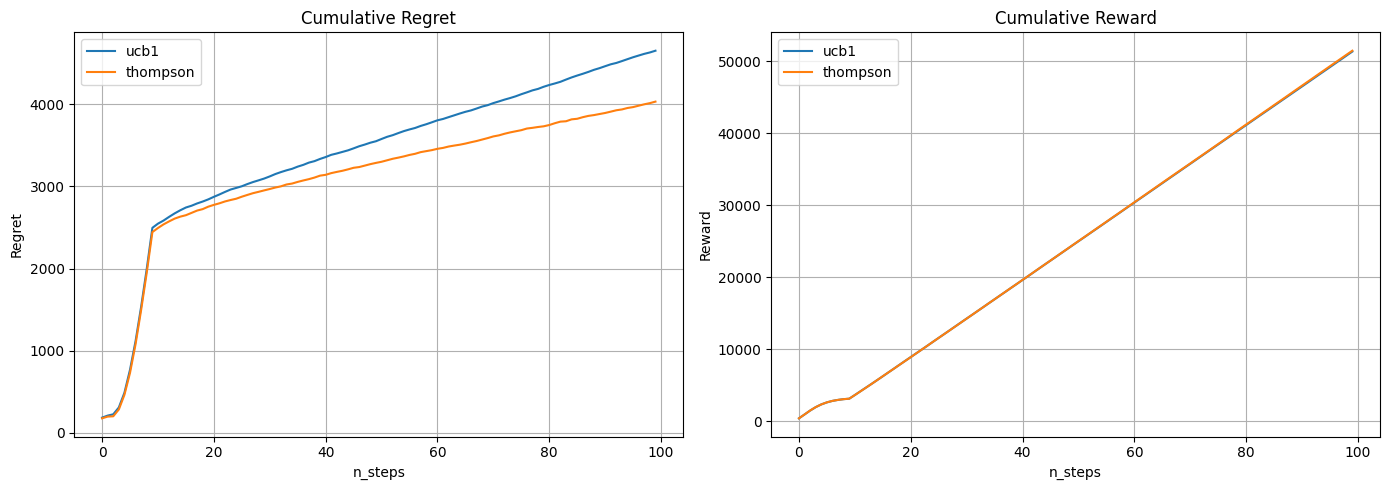

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
i = 0
for metric, metric_curves in curves.items():
    for strategy_type, metric_values in metric_curves.items():
        axes[i].plot(metric_values, label=strategy_type)
    axes[i].set_title(f'Cumulative {metric}')
    axes[i].set_xlabel('n_steps')
    axes[i].set_ylabel(metric)
    axes[i].legend()
    axes[i].grid(True)
    i += 1
    
plt.tight_layout()
plt.show()